In [1]:
import pandas as pd
import itertools
from scipy.stats import pearsonr, spearmanr, kendalltau
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
n_individuals = [5, 10, 15, 20, 30]
runs = range(5)
folds = range(1, 10)

ensembled_scores = [
    pd.read_csv(f"../data/qtl_metrics/diqtl/n{n}_run{r}_l2_scores.csv.gz", index_col=0)
    for n, r in itertools.product(n_individuals, runs)
]
fold_scores = [
    [
        pd.read_csv(f"../data/qtl_metrics/diqtl/n{n}_run{r}_fold_{fold}_l2_scores.csv.gz", index_col=0)
        for fold in folds
    ]
    for n, r in itertools.product(n_individuals, runs)
]
concat_fold_scores = [pd.concat(fold_scores_, axis=0) for fold_scores_ in fold_scores]
scores = [
    pd.concat(
        [
            fold_scores_.loc[fold_scores_.index.isin(ensembled_scores_.index)],
            ensembled_scores_.loc[~ensembled_scores_.index.isin(fold_scores_.index)]
        ],
    axis=0)
    for fold_scores_, ensembled_scores_ in zip(concat_fold_scores, ensembled_scores)
]

In [16]:
ensembled_pearsons = pd.DataFrame(
    {
        "n": [n for n, r in itertools.product(n_individuals, runs)],
        "run": [r for n, r in itertools.product(n_individuals, runs)],
        "pearson": [pearsonr(scores["expt"], scores["pred"])[0] for scores in ensembled_scores]
    }
)
pearsons = pd.DataFrame(
    {
        "n": [n for n, r in itertools.product(n_individuals, runs)] + [58],
        "pearson": [pearsonr(scores["expt"], scores["pred"])[0] for scores in scores] + [0.542]
    }
)

Text(0, 0.5, 'Pearson (log L2 ref - alt)')

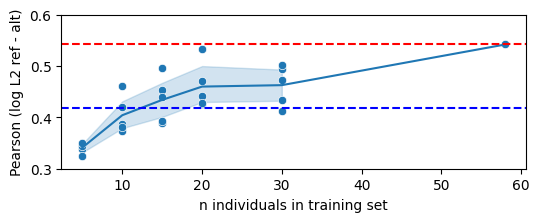

In [18]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(1, 1, 1)
sns.lineplot(data=pearsons, x="n", y="pearson")
sns.scatterplot(data=pearsons, x="n", y="pearson")
plt.axhline(y=0.542, color='r', linestyle='--')
plt.axhline(y=0.419, color='b', linestyle='--')
#ax.set_xlim(-5, 5)
ax.set_ylim(0.3, 0.6)

ax.set_xlabel("n individuals in training set")
ax.set_ylabel("Pearson (log L2 ref - alt)")
#plt.savefig("img/clipnet_diqtl_predictions.pdf")

In [19]:
spearmanr(pearsons.n.to_list() + [58], pearsons.pearson.to_list() + [0.542])

SignificanceResult(statistic=0.8078490352246575, pvalue=3.492636618715552e-07)

In [20]:
kendalltau(pearsons.n.to_list() + [58], pearsons.pearson.to_list() + [0.542])

SignificanceResult(statistic=0.6789347398332043, pvalue=2.9589274446431858e-06)